# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Grey Wolf Algorithm Application on Decision Tree Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer

from src.dataset import load_processed_data
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
%%time

x_train, y_train, x_test, y_test = load_processed_data(frac=0.01)

Number of records:
  x_train - 4724
  y_train - 4724
  x_test - 1181
  y_test - 1181
CPU times: user 35.6 s, sys: 3 s, total: 38.6 s
Wall time: 50.5 s


### Setup classification benchmark

In [4]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [5]:
columns_count = len(x_train.columns)
benchmark = ClassificationBenchmark(
    model_fn,
    lambda y_test, y_pred: roc_auc_score(y_test, y_pred),
    x_train,
    y_train,
    x_test,
    y_test
)

### Compare with baseline

In [6]:
def baseline(benchmark):
    """
    Evaluate model trained with all features.
    
    :param benchmark: NiaPy.Benchmark to evaluate
    """
    evaluate = benchmark.function()
    return 1 - evaluate(benchmark.get_length(), np.ones(columns_count))

We will compare optimizer with our baseline, which is using all of the columns.

In [7]:
baseline(benchmark)

0.6286349206349205

### Find optimal features

In [12]:
def optimize(benchmark, nGEN):
    """
    Optimize task with GWO optimizer.
    
    :param benchmark: NiaPy.Benchmark to optimize
    :param nGEN: number of generations
    """
    
    best_columns = None
    best_score = 0
    
    for i in range(5):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(D=benchmark.get_length(), nGEN=nGEN, optType=OptimizationType.MINIMIZATION, benchmark=benchmark)
        algo = GreyWolfOptimizer(NP=25)
        solution_vec, score = algo.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print(f'Score: {score}')
        print(columns)
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print('---')
    print(f'Score: {best_score}')
            
    return best_columns

Find the optimal combination of columns.

In [13]:
%%time

columns = optimize(benchmark, 100)

Score: 0.7326269841269842
['TransactionDT', 'C2', 'C4', 'C6', 'C13', 'V1', 'V6', 'V12', 'V14', 'V19', 'V26', 'V30', 'V31', 'V32', 'V35', 'V37', 'V45', 'V46', 'V47', 'V49', 'V56', 'V58', 'V64', 'V65', 'V66', 'V68', 'V75', 'V82', 'V87', 'V93', 'V94', 'V96', 'V100', 'V109', 'V110', 'V112', 'V117', 'V121', 'V136', 'V281', 'V283', 'V286', 'V291', 'V292', 'V294', 'V300', 'V303', 'V306', 'V309', 'V311', 'V314', 'V318', 'V320', 'V321', 'ProductCD_other', 'card2_490.0', 'card5_other', 'P_emaildomain_nan', 'P_emaildomain_yahoo', 'M4_M1', 'M6_T']


Score: 0.7290714285714286
['TransactionDT', 'C1', 'C3', 'C4', 'C8', 'C9', 'C11', 'C13', 'D1', 'D3', 'D10', 'V2', 'V4', 'V9', 'V13', 'V15', 'V16', 'V18', 'V22', 'V23', 'V24', 'V25', 'V30', 'V33', 'V34', 'V39', 'V40', 'V41', 'V44', 'V45', 'V47', 'V48', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V64', 'V69', 'V70', 'V72', 'V74', 'V77', 'V78', 'V79', 'V88', 'V95', 'V97', 'V102', 'V103', 'V107', 'V113', 'V114', 'V116', 'V119', 'V126', 'V128', 'V131', 'V135'

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

In comparison with the baseline model, the best solution by GWO is better by more than 10 percentual points.

### Train final classifier

We will train the model with selected features on the whole dataset.

In [14]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


Select columns based on the opmtimization result.

In [16]:
x_train = x_train[columns]
x_test = x_test[columns]

Train the final classifier.

In [17]:
%%time

clf = model_fn()
clf = clf.fit(x_train, y_train)

CPU times: user 11 s, sys: 10.4 ms, total: 11 s
Wall time: 11 s


Evaluate.

not fraud
precision: 0.986817838511935
recall: 0.981208030248784
f1-score: 0.9840049390716471
support: 114517


is fraud
precision: 0.4926921263554927
recall: 0.582010582010582
f1-score: 0.5336397293501851
support: 3591


accuracy: 0.9690706810715616


macro avg
precision: 0.7397549824337138
recall: 0.7816093061296829
f1-score: 0.7588223342109162
support: 118108


weighted avg
precision: 0.9717942547381535
recall: 0.9690706810715616
f1-score: 0.970311866052802
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
micro: 0.7397549824337138
macro: 0.7397549824337138
samples: 0.7397549824337138
weighted: 0.7397549824337138


CPU times: user 651 ms, sys: 2.31 ms, total: 653 ms
Wall time: 677 ms


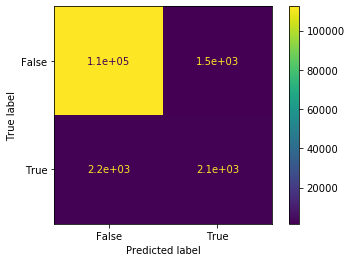

In [18]:
%%time

custom_classification_report(clf, x_test, y_test)